# LSTM base net

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

import ipdb
import dan_utils

In [2]:
# 设置随机数种子
seed = 25
dan_utils.setup_seed(seed)

# Load data

In [3]:
class_set = [2, 3, 4]
randseed = 25
res = 11
v, v_class, id_402, part1, part2, seg, det_list_class, near_road_set  \
        = dan_utils.load_data(class_set, res, randseed)
class_color_set = ['b', 'g', 'y', 'black', 'r']

# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_src = 3
v_class1 = v_class[class_src]  # source
near_road1 = np.array(near_road_set[class_src])

class_tar = 2
v_class2 = v_class[class_tar]  # target
near_road2 = np.array(near_road_set[class_tar])

num_links = v_class1.shape[0]

near_road_src = near_road1
flow_src = v_class1.iloc[:, 2:-1]
prop = 1  # proportion of training data
from_day = 1
to_day = 24

image_train_source, image_test_source, day_train_source, day_test_source, label_train_source, label_test_source\
= dan_utils.sliding_window(
    flow_src, near_road_src, from_day, to_day, prop, num_links
)

near_road_tar = near_road2
flow_tar = v_class2.iloc[:, 2:-1]
prop = 3/10
from_day = 22
to_day = 31

image_train_target, image_test_target, day_train_target, day_test_target, label_train_target, label_test_target\
= dan_utils.sliding_window(
    flow_tar, near_road_tar, from_day, to_day, prop, num_links
)

dup_mul = image_train_source.shape[0]//image_train_target.shape[0]
dup_r   = image_train_source.shape[0]%image_train_target.shape[0]

image_train_target, day_train_target, label_train_target = \
np.concatenate((np.tile(image_train_target, [dup_mul, 1, 1, 1]), image_train_target[:dup_r, :, :, :]), axis=0),\
np.concatenate((np.tile(day_train_target, [dup_mul, 1, 1]), day_train_target[:dup_r, :, :]), axis=0),\
np.concatenate((np.tile(label_train_target, [dup_mul, 1, 1]), label_train_target[:dup_r, :, :]), axis=0),



There are 5 class(es)


C:\Users\10169\anaconda3\envs\dan_traff\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


(2772, 5, 12, 75)
(2772, 5, 12, 75)
(0, 5, 12, 75)
(2772, 75, 6)
(0, 75, 6)
(1008, 5, 12, 90)
(302, 5, 12, 90)
(706, 5, 12, 90)
(302, 90, 6)
(706, 90, 6)


In [4]:
v_class2 = v_class2.iloc[:, 2:-1]
tar_flow = np.array(v_class2.iloc[:, 4466-144*10-1:4466-144-1], dtype=float)

# Data assembling

In [5]:
def sliding_window(data, window_size, prop):
    pred_samp = 6
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     data = data.flatten()
    data_out = []
    label_out = []
    for i in range(data.shape[1] - window_size - pred_samp):
        data_out.append(data[:, i : i + window_size])
        label_out.append(data[:, i + window_size + 1: i + window_size + 1 + pred_samp])  # to predict the next 3 flows
    data_out = np.array(data_out)
    label_out = np.array(label_out)
#     ipdb.set_trace()
    train_data_out = torch.tensor(data_out[:int(data_out.shape[0]*prop), :], dtype=torch.float32).to(device)
    train_label_out = torch.tensor(label_out[:int(data_out.shape[0]*prop)], dtype=torch.float32).to(device)
    val_data_out = torch.tensor(data_out[int(data_out.shape[0]*prop):, :], dtype=torch.float32).to(device)
    val_label_out = torch.tensor(label_out[int(data_out.shape[0]*prop):], dtype=torch.float32).to(device)
    
    train_data_out = torch.transpose(train_data_out, 1, 2)
    train_label_out = torch.transpose(train_label_out, 1, 2)
    val_data_out = torch.transpose(val_data_out, 1, 2)
    val_label_out = torch.transpose(val_label_out, 1, 2)
    
    return train_data_out, train_label_out, val_data_out, val_label_out


In [8]:
window_size = 10
batch_size = 5760
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tar_train_data, tar_train_label, tar_val_data, tar_val_label = sliding_window(tar_flow, window_size, 0.3)

tar_train_loader = torch.utils.data.DataLoader(
    TensorDataset(tar_train_data, tar_train_label), batch_size, shuffle=True
)

tar_iter = iter(tar_train_loader)

In [9]:
print(tar_train_data.shape)
print(tar_train_label.shape)
print(tar_val_data.shape)
print(tar_val_label.shape)

torch.Size([384, 10, 90])
torch.Size([384, 6, 90])
torch.Size([896, 10, 90])
torch.Size([896, 6, 90])


# LSTM network (base)

In [45]:
class traffic_base_net(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dim, layers):
        super(traffic_base_net, self).__init__()
        self.batch_first = True

        self.out_dim = out_dim
        
        self.lstm = nn.LSTM(inp_dim, hid_dim, layers, dropout=0.3)
        
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim)
        )  # regression
    
    def forward(self, x):
        # input size: (batchsize, seq_len, input_dim)
        # output size: (batchsize, seq_len, hid_dim)
        # ipdb.set_trace()
        y = self.lstm(x)[0]  # y, (h, c) = self.rnn(x)
        
        y = self.fc(y[:, -6:, :])  # fully connected layer
        
        return y

# Training on target data

In [54]:
inp_dim = 40
out_dim = 40
hid_dim = 40
layers = 3

In [55]:
traff_node_base = traffic_base_net(inp_dim, out_dim, hid_dim, layers).to(device)

loss_func = nn.MSELoss()
val_loss_set = []
train_loss_set = []

#summary(traff_node_dannet, input_size=(batch_size, window_size), device=device)

In [76]:
optimizer = optim.Adam(traff_node_base.parameters())

In [77]:
traff_node_base.train()

epochs = 1001

# assert len(src_loader) == len(tar_loader)
   
for e in range(epochs):
    #ipdb.set_trace()
    for i in range(len(src_train_loader)):
        try:
            tar_data, tar_label = tar_iter.next()
        except:
            tar_iter = iter(tar_train_loader)
            tar_data, tar_label = tar_iter.next()
        
        tar_out = traff_node_base(tar_data)
        #ipdb.set_trace()
        loss = loss_func(tar_out, tar_label)  # target dataset loss

        val_out = traff_node_base(tar_val_data)
        val_loss = loss_func(val_out, tar_val_label)
        #ipdb.set_trace()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        val_loss_set.append(val_loss.cpu().detach().numpy())
        train_loss_set.append(loss.cpu().detach().numpy())
    if e%50==0:
        print('Epoch %i success, val loss:%.5f, train loss:%.5f'%(e, val_loss.cpu().detach().numpy(), loss.cpu().detach().numpy()))

Epoch 0 success, val loss:41860.25391, train loss:41264.25000
Epoch 50 success, val loss:41854.05859, train loss:41259.86328
Epoch 100 success, val loss:41853.21875, train loss:41135.25000
Epoch 150 success, val loss:41857.70312, train loss:41046.94141
Epoch 200 success, val loss:41856.46875, train loss:41260.65234
Epoch 250 success, val loss:41854.55469, train loss:40988.65234
Epoch 300 success, val loss:41856.28906, train loss:41219.37891
Epoch 350 success, val loss:41854.87109, train loss:41234.63281
Epoch 400 success, val loss:41858.44922, train loss:41203.78516
Epoch 450 success, val loss:41859.75391, train loss:41234.46875
Epoch 500 success, val loss:41856.01562, train loss:41040.23828
Epoch 550 success, val loss:41856.57812, train loss:41268.42578
Epoch 600 success, val loss:41854.04297, train loss:41239.42969
Epoch 650 success, val loss:41852.82422, train loss:40980.03906
Epoch 700 success, val loss:41854.26953, train loss:41275.02344
Epoch 750 success, val loss:41854.67188, tr

# Visualization

In [78]:
def plot_loss(val, train, title):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(val)
    ax1.set_xlabel('Batches')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(val)])
    ax1.set_title('Validation loss')
    ax1.grid()
    ax2 = fig.add_subplot(122)
    ax2.plot(train)
    ax2.set_xlabel('Batches')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Train loss')
    ax2.grid()
    plt.suptitle(title)

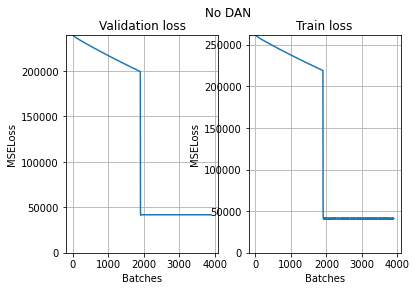

In [79]:
plot_loss(val_loss_set, train_loss_set, 'No DAN')

In [80]:
val_out.shape

torch.Size([896, 6, 40])

Text(0.5, 1.0, 'Target dataset')

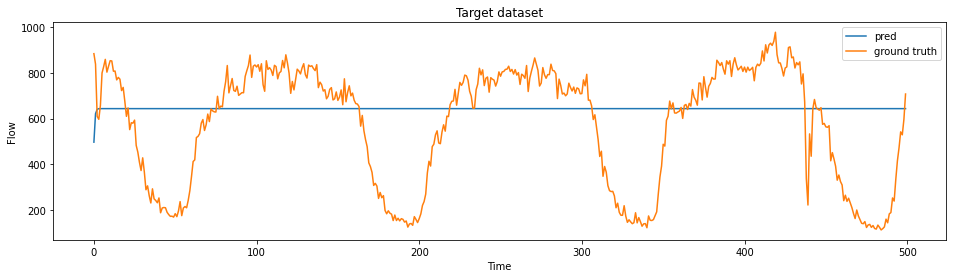

In [81]:
plt.figure(figsize=[16,4])
plt.plot(val_out[:500, -3, 0].cpu().detach().numpy(), label='pred')
plt.plot(tar_val_label[:500, -3, 0].cpu().detach().numpy(), label='ground truth')
plt.legend()
plt.xlabel('Time')  # time gran: 15 min
plt.ylabel('Flow')
plt.title('Target dataset')

# Evaluation

In [82]:
def denorm_data(vec, min_val, max_val):
    return vec*(max_val - min_val) + min_val

In [83]:
# traff_node_dannet = torch.load('./model/traff_node_dannet.pth')
traff_node_base.eval()

val_out = traff_node_base(tar_val_data).cpu().detach().numpy()
val_out_denormed = denorm_data(val_out, tar_min, tar_max)
tar_val_label_denormed = denorm_data(tar_val_label.cpu().detach().numpy(), tar_min, tar_max)
i=0
j=1
m=.05
mape=dan_utils.mape_loss_func(val_out_denormed[:, i, j], tar_val_label_denormed[:, i, j], m)
nrmse=dan_utils.nrmse_loss_func(val_out_denormed, tar_val_label_denormed, m)
print('MAPE: %.5f'%mape)
print('SMAPE: %.5f'%dan_utils.smape_loss_func(val_out_denormed, tar_val_label_denormed, m))
print('MAE: %.5f'%dan_utils.mae_loss_func(val_out_denormed, tar_val_label_denormed, m))
print('NRMSE: %.5f'%nrmse)


MAPE: 0.76330
SMAPE: 0.45931
MAE: 124633.50542
NRMSE: 0.25966


In [84]:
torch.save(traff_node_base.state_dict(), '../model/base_LSTM_mape=%.5f_nrmse=%.5f.h5'%(mape, nrmse))
torch.cuda.empty_cache()

C:\Users\10169\AppData\Local\Temp/ipykernel_9596/1232258740.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


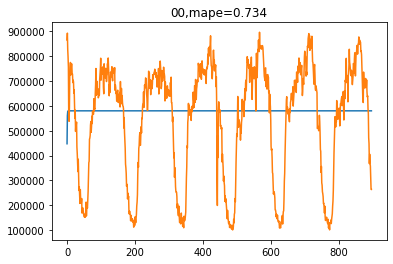

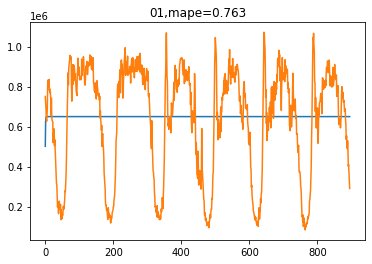

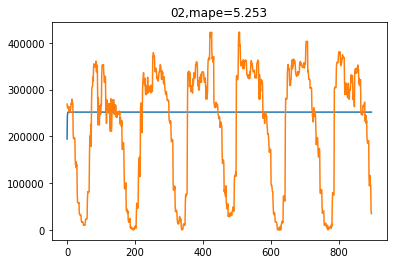

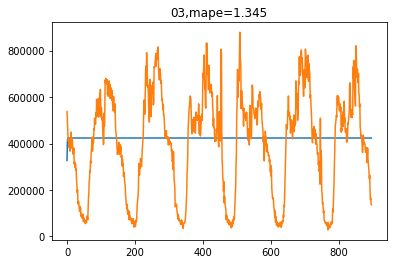

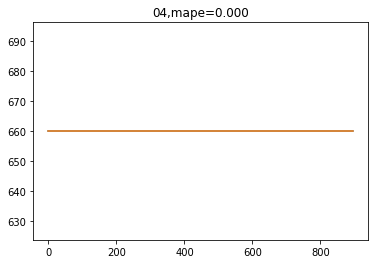

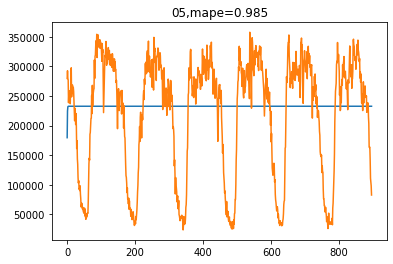

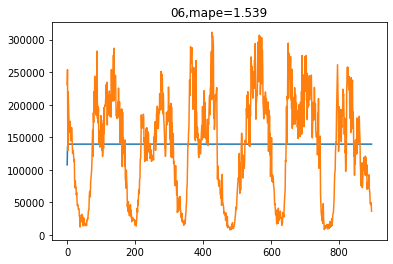

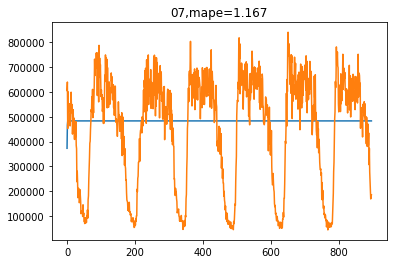

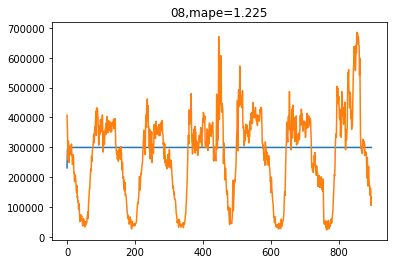

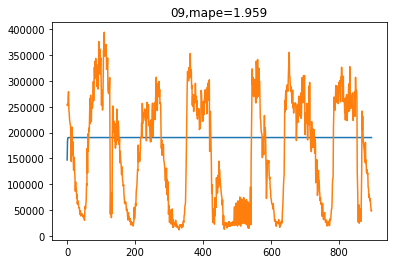

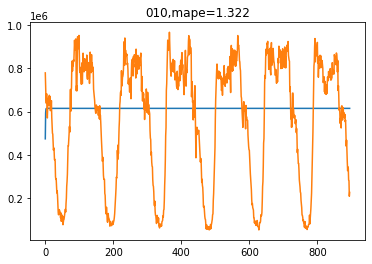

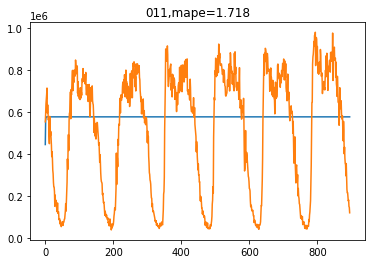

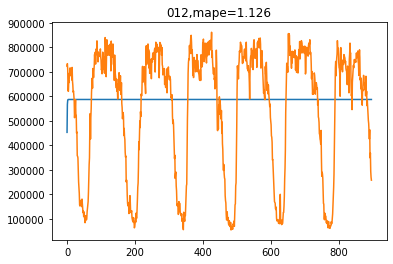

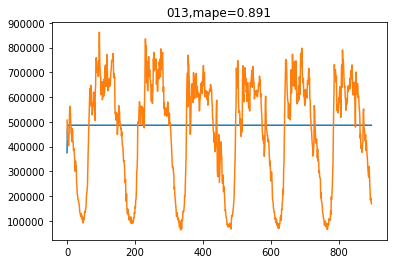

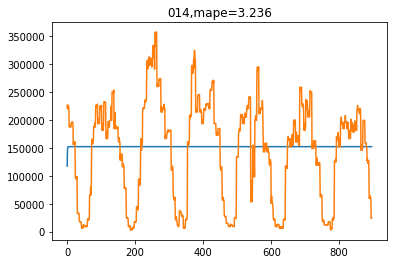

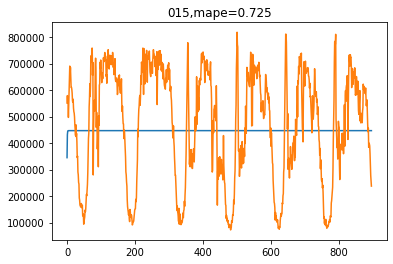

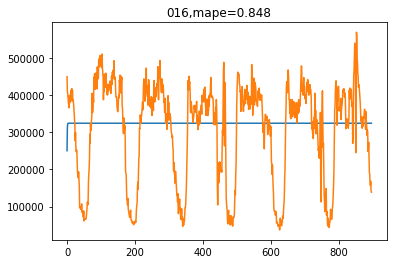

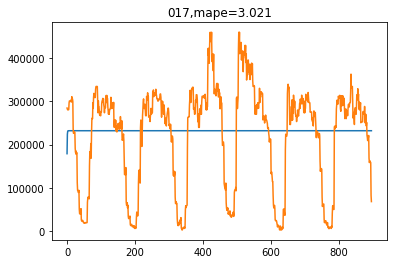

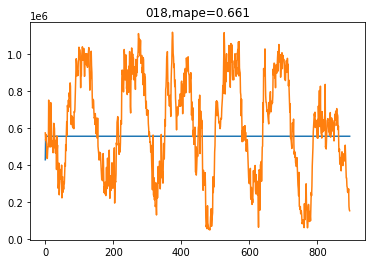

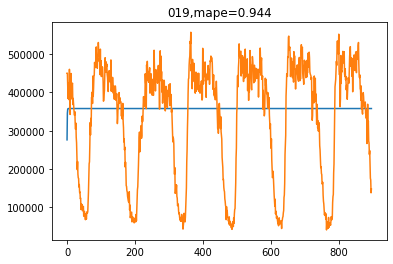

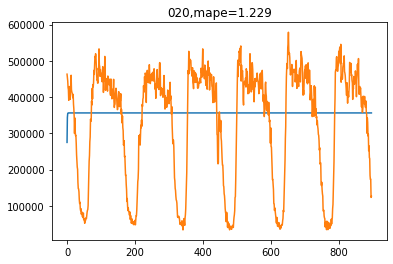

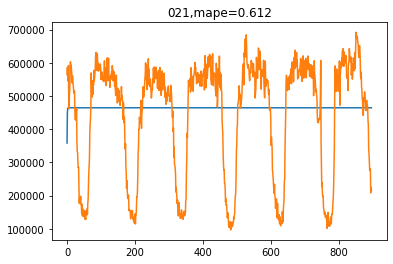

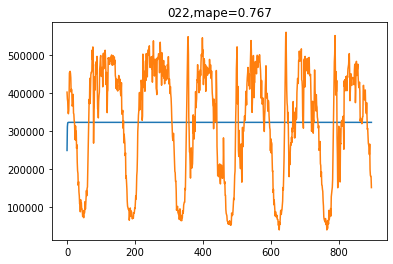

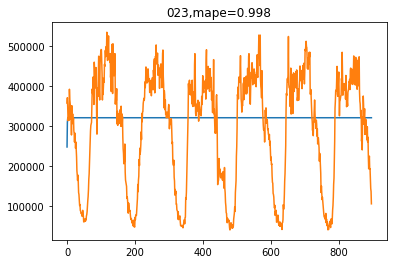

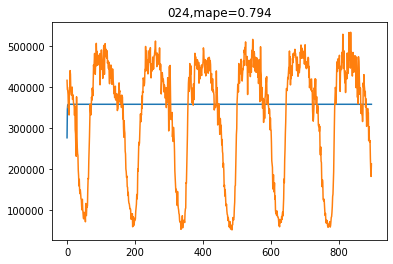

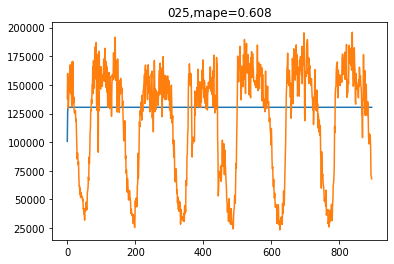

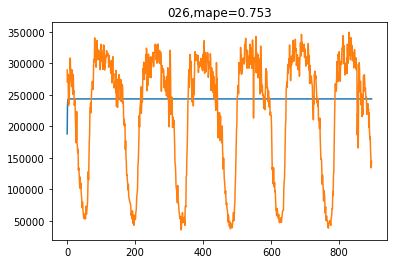

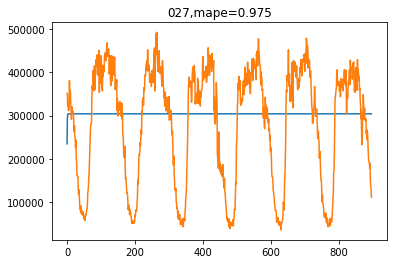

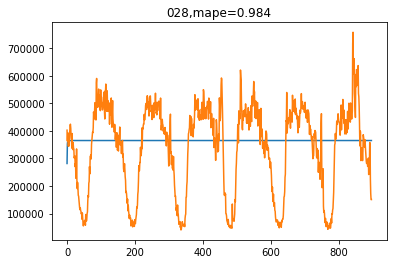

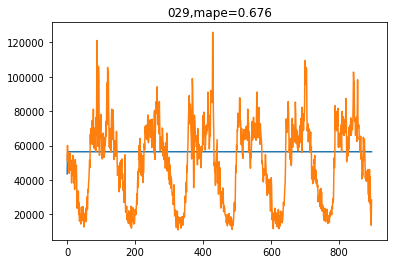

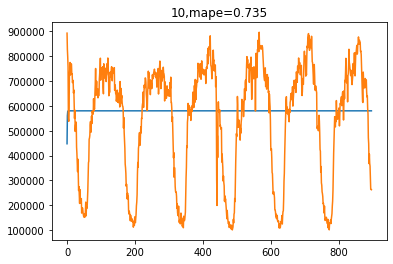

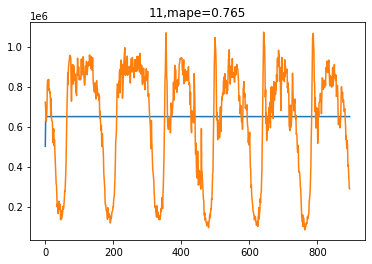

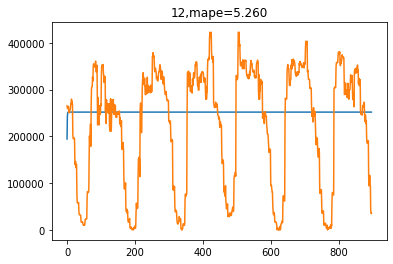

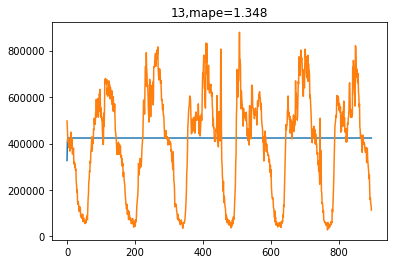

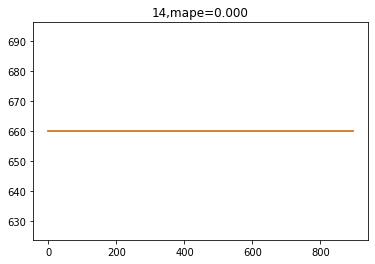

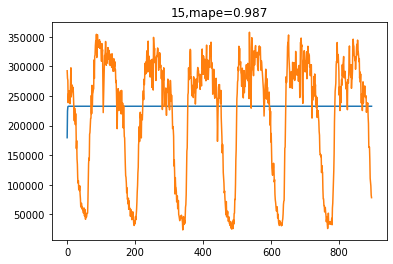

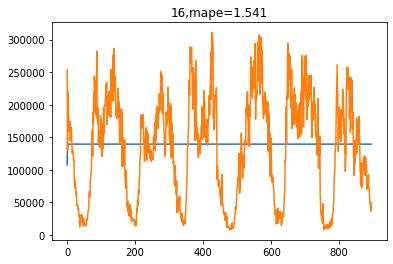

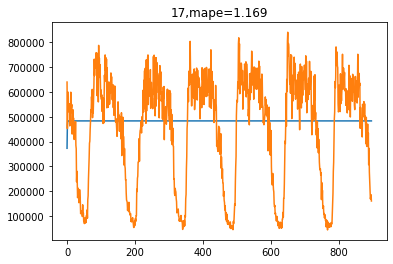

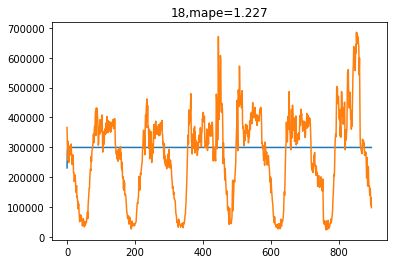

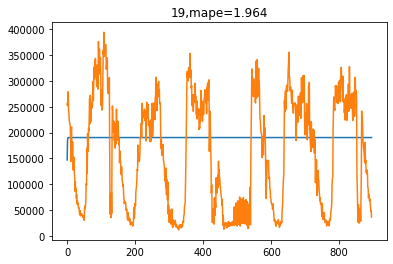

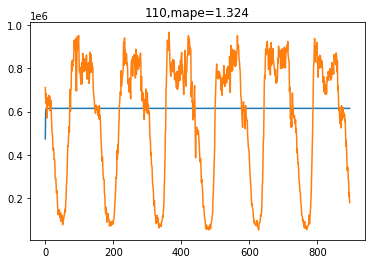

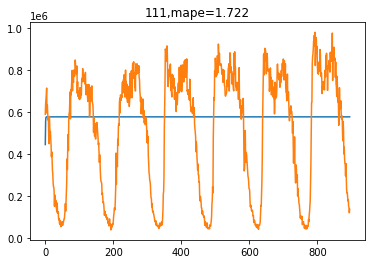

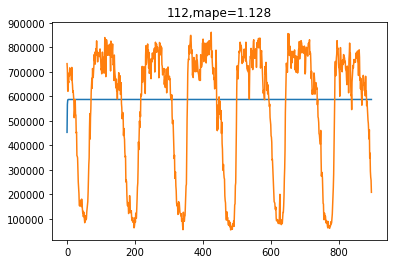

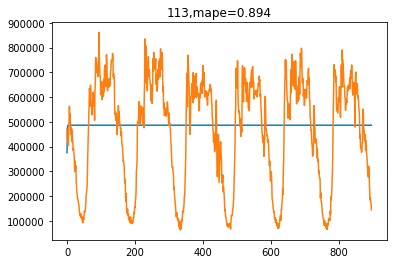

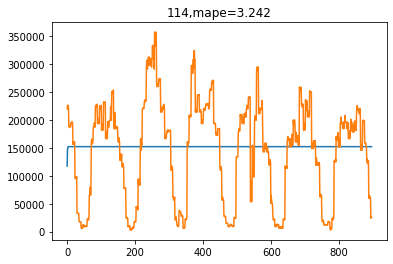

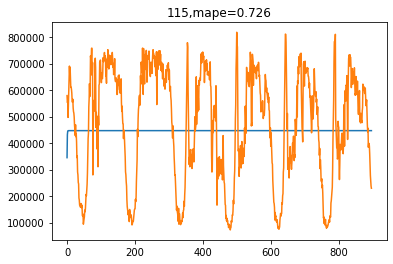

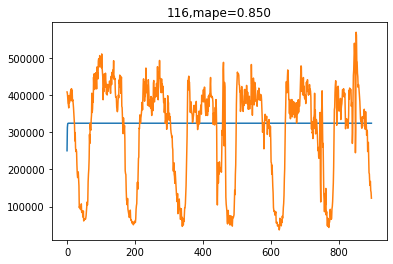

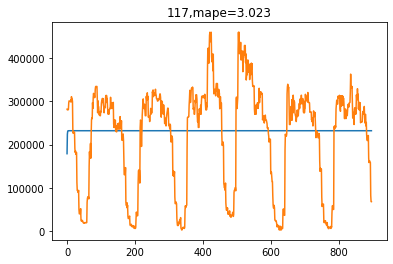

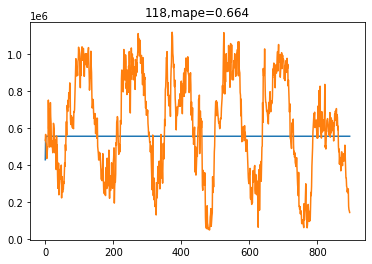

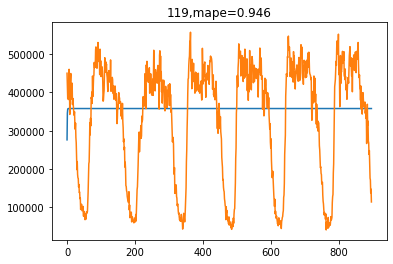

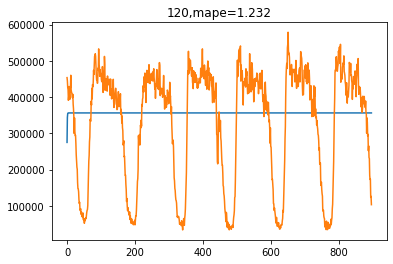

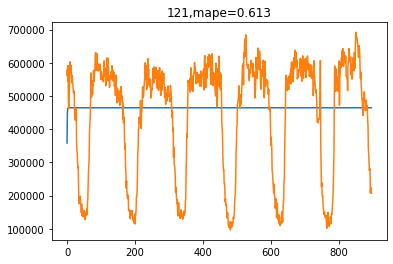

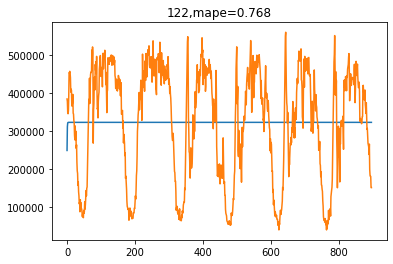

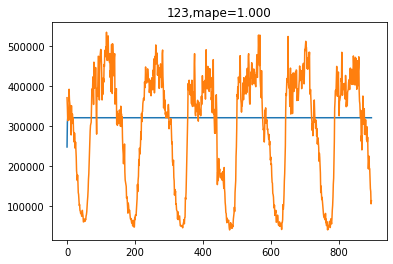

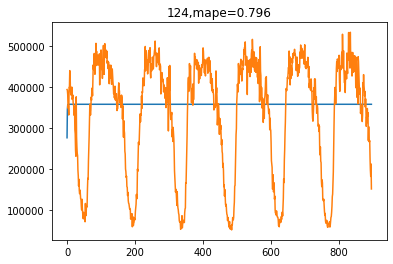

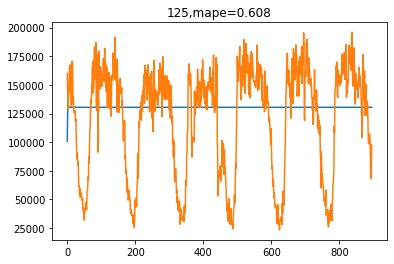

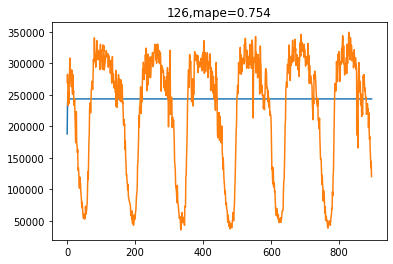

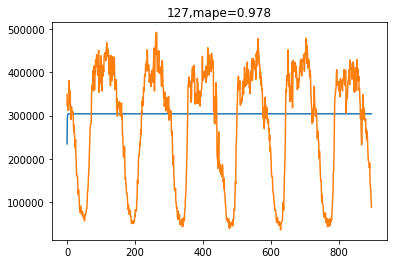

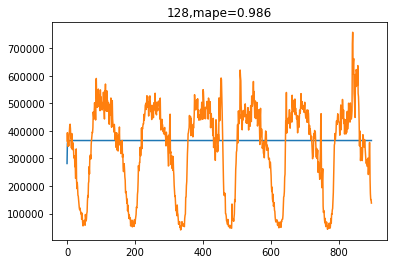

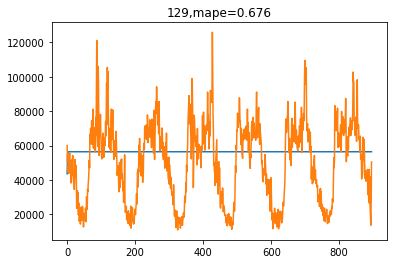

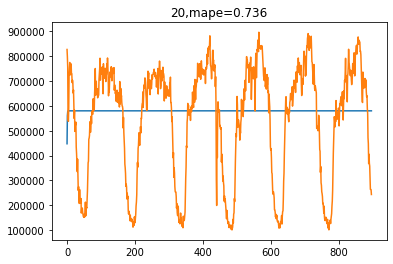

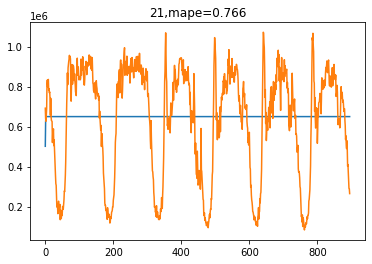

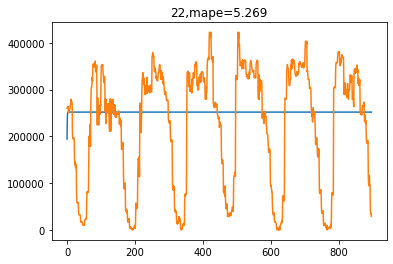

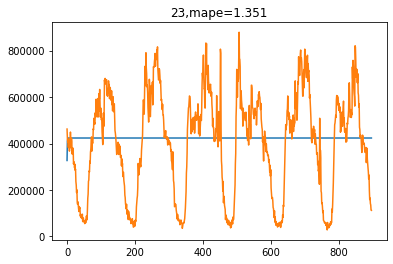

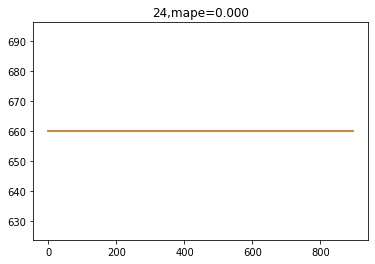

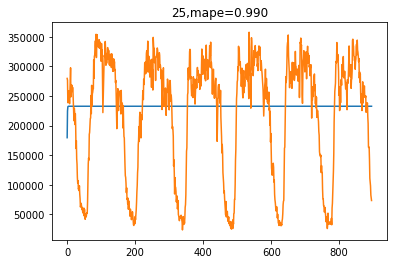

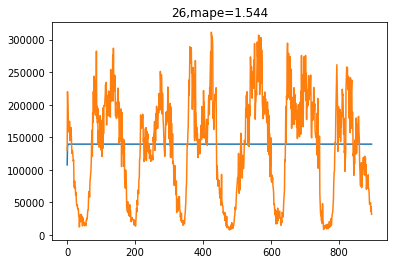

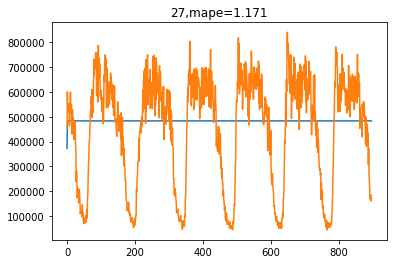

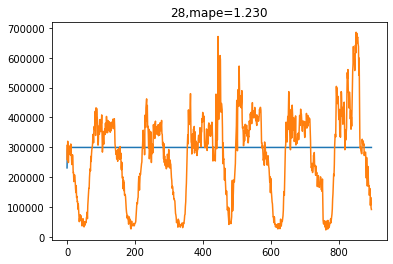

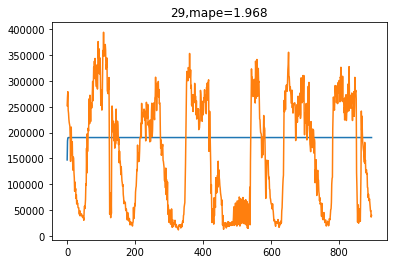

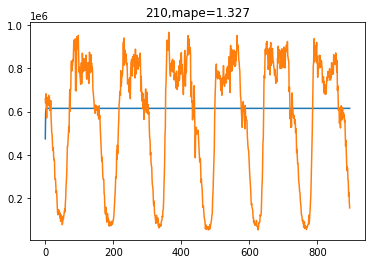

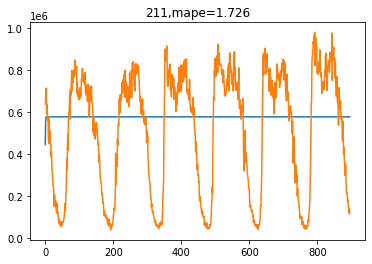

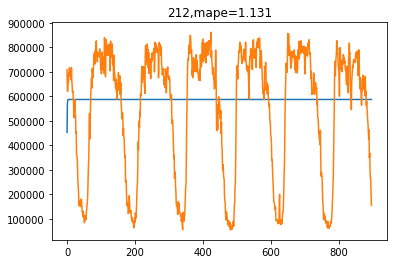

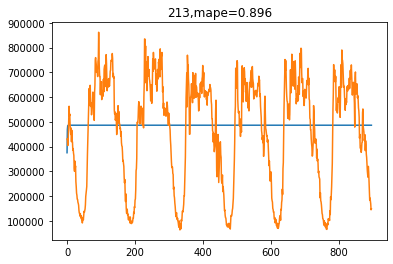

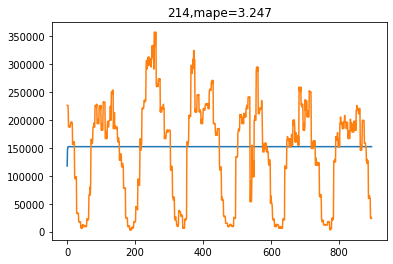

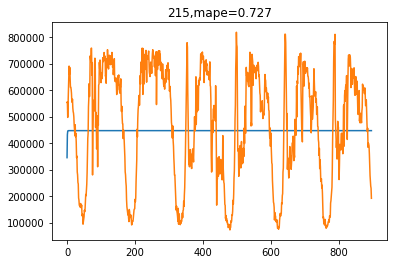

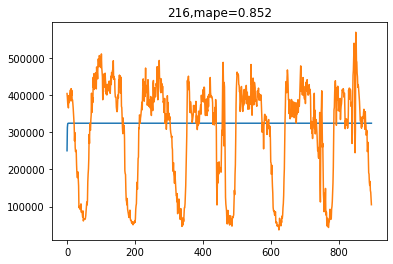

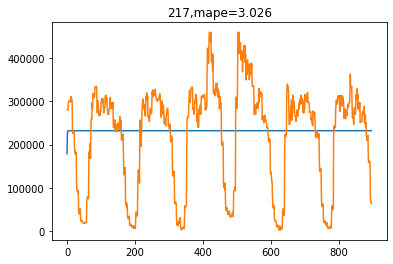

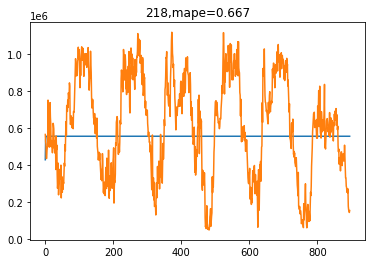

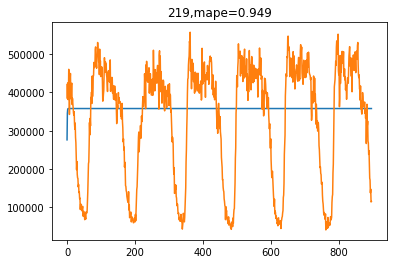

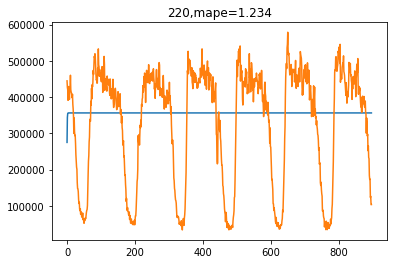

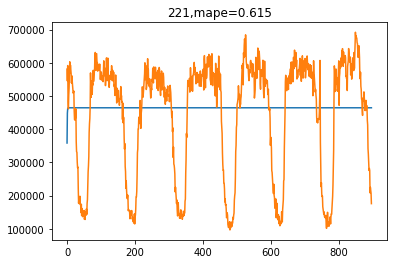

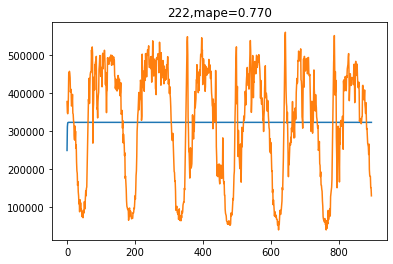

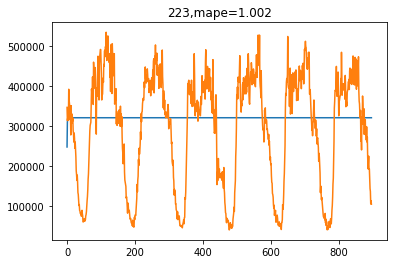

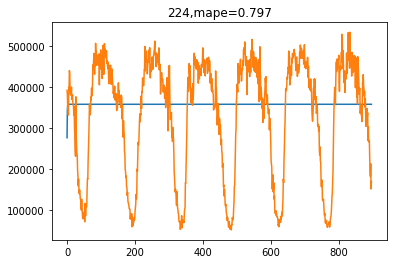

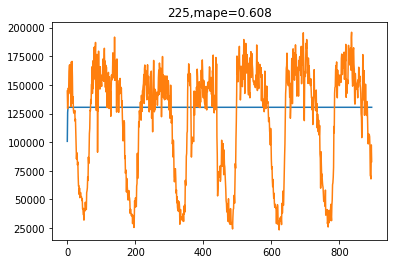

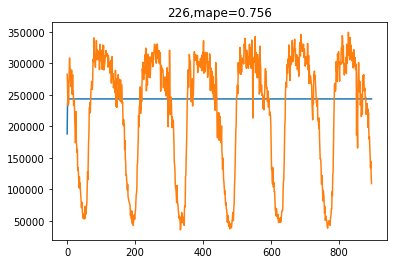

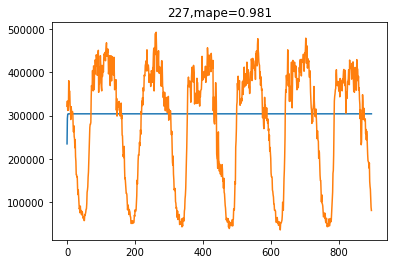

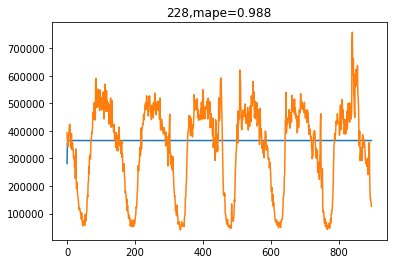

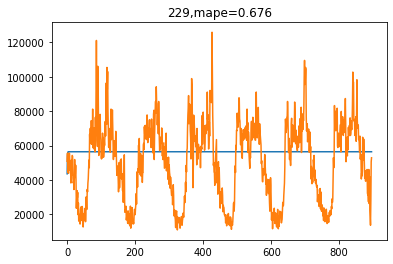

In [85]:
mape_set = []
for i in range(3):
    for j in range(30):
        plt.figure()
        plt.plot(val_out_denormed[:, i, j])
        plt.plot(tar_val_label_denormed[:, i, j])
        mape = mape_loss_func(val_out_denormed[:, i, j], tar_val_label_denormed[:, i, j])
        mape_set.append(mape)
        plt.title('%i%i,mape=%.3f'%(i, j, mape))